In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit

In [6]:
import sys
sys.path.append('../src') 

In [7]:
from cnn_aux import files_list_npy_csv, select_image_and_lbl, get_energy, mean_rms

In [8]:
from cnn_dl import GIDataset, mono_data_loader
from cnn_models import CNN_basic
from cnn_plot import histoplot, plot_images,scatter_xyz, scatter_xyze
from cnn_plot import plot_images_ds, plot_loss, plotxyz, plotxyz_twoc
from cnn_eval import train_cnn, evaluate_cnn
from cnn_fit import fit_tdeltas, plotfxyz

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [10]:
data_dir = Path(os.environ['DATA'])
imgdir = os.path.join(data_dir,"G4Prods/crystalGI", "CSIH1")
g4dir = os.path.join(data_dir,"G4Prods/crystalGI", "G4CSIH1")
fsp = "sensor_positions.csv"

# Setup

- CsI (Tl) crystal (50k phot/MeV)
- gammas interact uniformly in x,y and according to X0 in z

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- crystalGI simulation


### read dataframe with sensor positions

In [11]:
dfs = pd.read_csv(f"{g4dir}/{fsp}", header=0)
dfs.head(10)

,sensor_id,sensor_x,sensor_y,sensor_z
0,0,-21,-21,19.1
1,1,-21,-15,19.1
2,2,-21,-9,19.1
3,3,-21,-3,19.1
4,4,-21,3,19.1
5,5,-21,9,19.1
6,6,-21,15,19.1
7,7,-21,21,19.1
8,8,-15,-21,19.1
9,9,-15,-15,19.1


### select image and metadata for a given file number

In [12]:
imgs, mdata = select_image_and_lbl(imgdir, 0)

Selected files: img = images_0.npy, metdata = metadata_0.csv


In [13]:
mdata.head(10)

,event,etot,ntrk,t1,x1,y1,z1,e1,t2,x2,y2,z2,e2
0,0,511.0,2,45.1,20.2,-6.4,-5.0,297.7,57.6,16.7,-6.7,-6.5,213.3
1,4,511.0,2,90.5,9.2,-4.0,8.6,332.2,103.3,8.3,-5.8,5.4,178.8
2,5,511.1,5,82.8,0.6,11.5,6.3,14.3,95.0,1.5,11.6,9.9,94.3
3,6,511.0,1,12.2,7.3,1.1,-14.8,511.0,12.2,7.3,1.1,-14.8,511.0
4,8,511.0,1,7.1,-17.6,-23.4,-16.4,511.0,7.1,-17.6,-23.4,-16.4,511.0
5,9,511.0,2,98.7,21.4,19.2,11.1,338.7,115.2,20.1,19.2,6.3,172.3
6,10,511.0,1,22.8,-14.2,1.7,-11.7,511.0,22.8,-14.2,1.7,-11.7,511.0
7,11,511.0,1,32.6,-14.9,-2.9,-8.7,511.0,32.6,-14.9,-2.9,-8.7,511.0
8,14,511.0,4,17.4,-13.9,9.2,-13.3,45.5,95.9,-6.6,11.8,8.4,149.7
9,15,511.0,3,44.3,6.9,14.1,-5.2,215.2,63.2,12.3,13.6,-3.7,143.4


In [14]:
m2 = mdata.drop(["event", "etot", "ntrk", "t1", "t2"], axis=1)
m2.head(10)

,x1,y1,z1,e1,x2,y2,z2,e2
0,20.2,-6.4,-5.0,297.7,16.7,-6.7,-6.5,213.3
1,9.2,-4.0,8.6,332.2,8.3,-5.8,5.4,178.8
2,0.6,11.5,6.3,14.3,1.5,11.6,9.9,94.3
3,7.3,1.1,-14.8,511.0,7.3,1.1,-14.8,511.0
4,-17.6,-23.4,-16.4,511.0,-17.6,-23.4,-16.4,511.0
5,21.4,19.2,11.1,338.7,20.1,19.2,6.3,172.3
6,-14.2,1.7,-11.7,511.0,-14.2,1.7,-11.7,511.0
7,-14.9,-2.9,-8.7,511.0,-14.9,-2.9,-8.7,511.0
8,-13.9,9.2,-13.3,45.5,-6.6,11.8,8.4,149.7
9,6.9,14.1,-5.2,215.2,12.3,13.6,-3.7,143.4


In [15]:
m2o = m2[['x1', 'y1', 'z1','x2','y2','z2','e1','e2']]
m2o.head(10)

,x1,y1,z1,x2,y2,z2,e1,e2
0,20.2,-6.4,-5.0,16.7,-6.7,-6.5,297.7,213.3
1,9.2,-4.0,8.6,8.3,-5.8,5.4,332.2,178.8
2,0.6,11.5,6.3,1.5,11.6,9.9,14.3,94.3
3,7.3,1.1,-14.8,7.3,1.1,-14.8,511.0,511.0
4,-17.6,-23.4,-16.4,-17.6,-23.4,-16.4,511.0,511.0
5,21.4,19.2,11.1,20.1,19.2,6.3,338.7,172.3
6,-14.2,1.7,-11.7,-14.2,1.7,-11.7,511.0,511.0
7,-14.9,-2.9,-8.7,-14.9,-2.9,-8.7,511.0,511.0
8,-13.9,9.2,-13.3,-6.6,11.8,8.4,45.5,149.7
9,6.9,14.1,-5.2,12.3,13.6,-3.7,215.2,143.4


In [16]:
mdata.drop(["event", "etot", "ntrk", "t1", "t2","e1", "e2"], axis=1)

,x1,y1,z1,x2,y2,z2
0,20.2,-6.4,-5.0,16.7,-6.7,-6.5
1,9.2,-4.0,8.6,8.3,-5.8,5.4
2,0.6,11.5,6.3,1.5,11.6,9.9
3,7.3,1.1,-14.8,7.3,1.1,-14.8
4,-17.6,-23.4,-16.4,-17.6,-23.4,-16.4
...,...,...,...,...,...,...
6774,11.8,12.6,17.5,10.5,10.3,16.8
6775,-10.8,0.3,-11.6,-10.8,0.3,-11.6
6776,-16.7,10.1,-17.9,-19.3,3.9,-17.8
6777,-8.1,14.7,-7.7,-8.1,14.7,-7.7


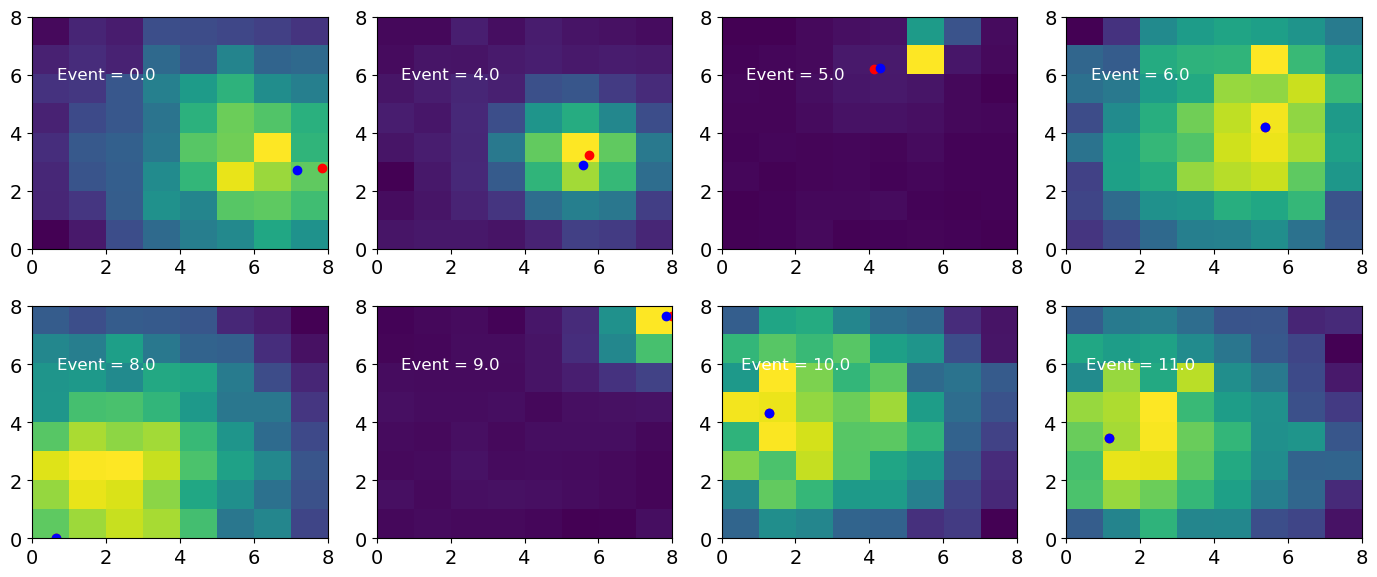

In [17]:
plot_images(imgs, mdata, dfs, range(0,8), figsize=(14, 6))

In [18]:
energy = get_energy(imgs)

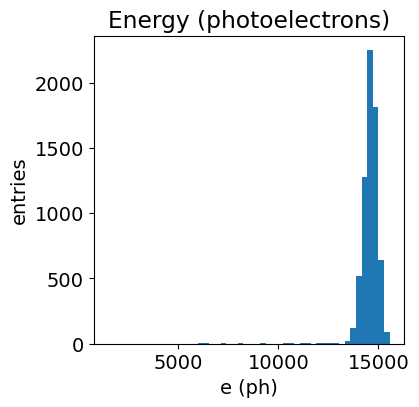

In [19]:
b, e = histoplot(energy, 'e (ph)', "entries", bins=50, figsize=(6,6),
                title="Energy (photoelectrons)")

In [22]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy[energy>13000])

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 14598.65 sigma = 2.29 % FWHM = 5.26 %


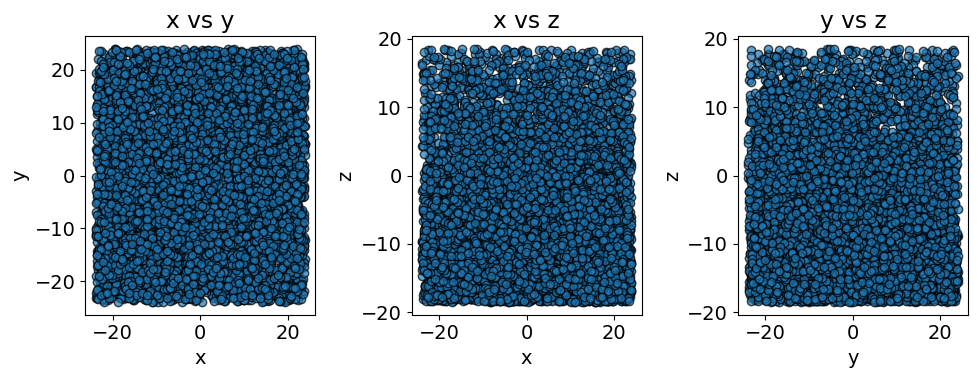

In [23]:
scatter_xyz(mdata.x1,mdata.y1,mdata.z1, figsize=(10, 4))

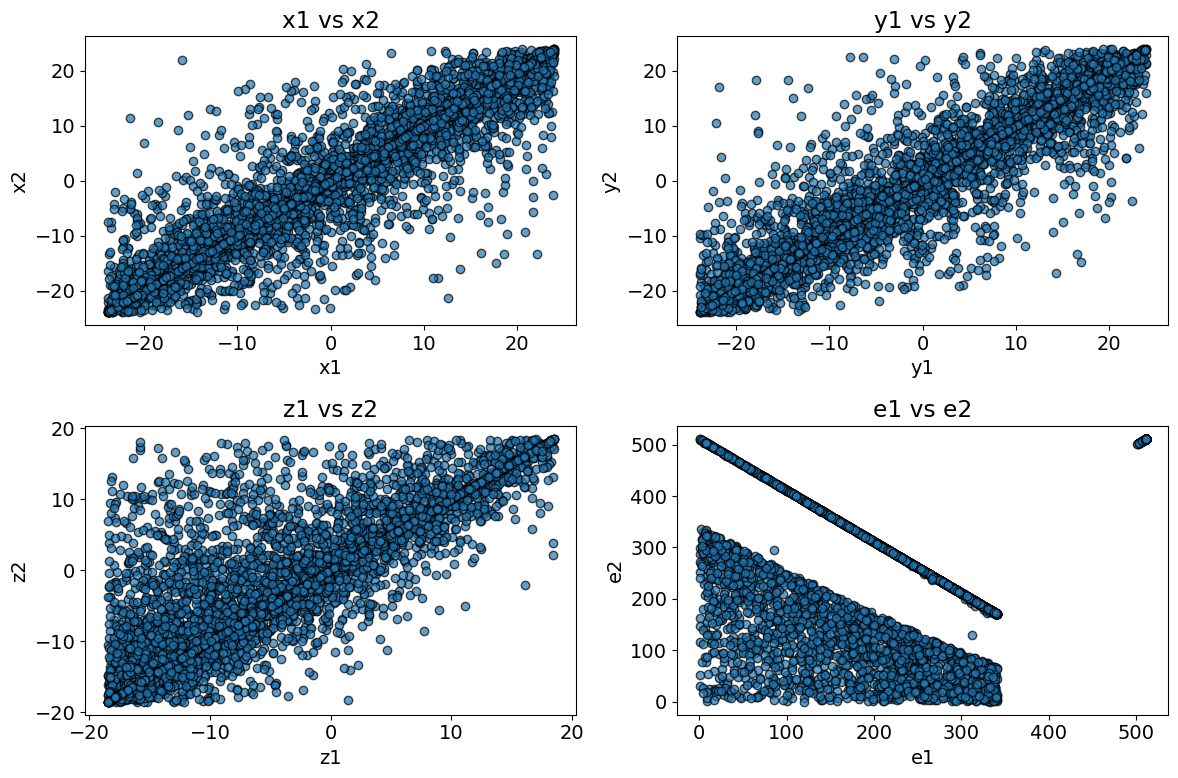

In [24]:
scatter_xyze(mdata, figsize=(12, 8))

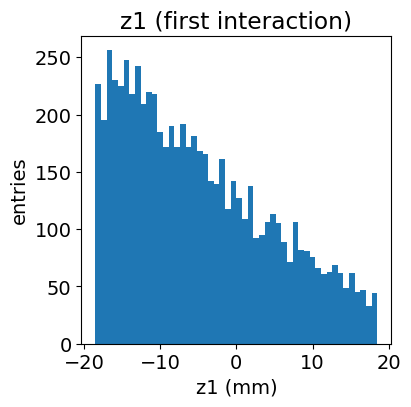

In [25]:
b, e = histoplot(mdata.z1, 'z1 (mm)', "entries", bins=50, figsize=(6,6),
                title="z1 (first interaction)")

## CNN run 1
- Use CNN_basic training only for (x,y,z), e.g, the first position of the gamma
- No normalization

In [26]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [27]:

dataset = GIDataset(imgdir, first_file, last_file,twoc=1) 


Running GIDataset with norm = False, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Loading images_0.npy, metadata_0.csv
Loading images_20.npy, metadata_20.csv
Loading images_40.npy, metadata_40.csv
Loading images_60.npy, metadata_60.csv
Loading images_80.npy, metadata_80.csv


In [28]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 676848 events
 train size = 473793
 val size = 135369
 test size = 67686
 train indices = range(0, 473793)
 val indices = range(473793, 609162)
 test indices = range(609162, 676848)
473793 training events (69.99991135380469%)
135369 validation events (19.999911353804695%)
67686 test events (10.00017729239061%)


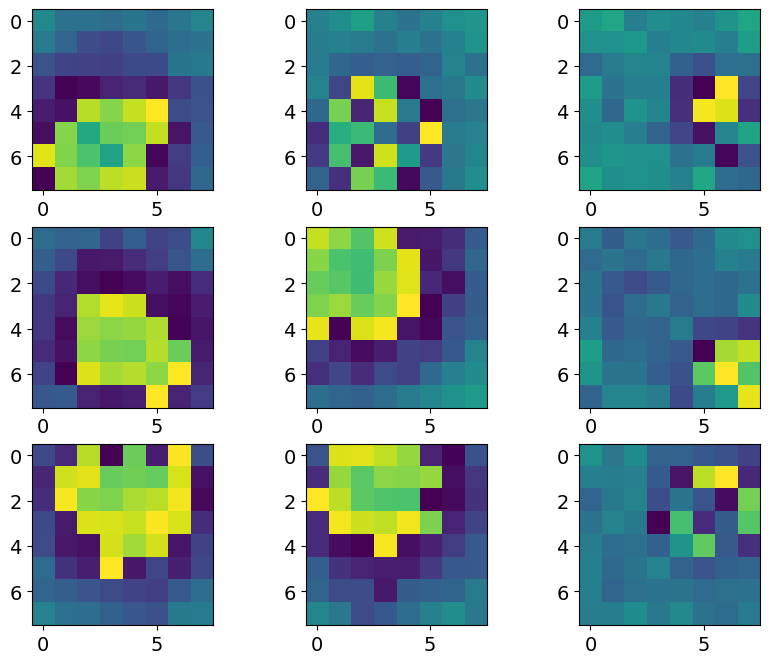

In [29]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [30]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 6])
tensor([[137., 155., 197., 202., 243., 235., 237., 196.],
        [143., 188., 216., 247., 275., 317., 297., 276.],
        [155., 212., 210., 272., 290., 334., 338., 271.],
        [169., 232., 244., 263., 310., 331., 338., 278.],
        [179., 195., 208., 255., 251., 316., 323., 291.],
        [159., 182., 203., 232., 267., 303., 286., 238.],
        [127., 166., 184., 229., 242., 231., 232., 215.],
        [175., 150., 182., 183., 203., 201., 184., 181.]])


In [31]:
model = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, twoc=1).to(device)

In [32]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [34]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->474000 images
size of train loader  ->474 images
Evaluating with  ->136000 images
size of eval loader  ->136 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 13.331429056980438
--- EPOCH 0 AVG VAL LOSS: 13.018970847129822

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 12.789871847579247
--- EPOCH 1 AVG VAL LOSS: 12.361193229170407

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 12.454820707377502
--- EPOCH 2 AVG VAL LOSS: 11.860479628338533

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 12.219252354988067
--- EPOCH 3 AVG VAL LOSS: 11.936811496229733

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 12.044158168985874
--- EPOCH 4 AVG VAL LOSS: 11.42874599905575

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 11.924729805958423
--- EPOCH 5 AVG VAL LOSS: 11.662624807918773

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 11.802881560748137
--- EPOCH 6 AVG VAL LOSS: 11.628313597510843

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 11.705023781659733
--- EPOCH 7 AVG VAL LOSS: 11.538094394347247

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS:

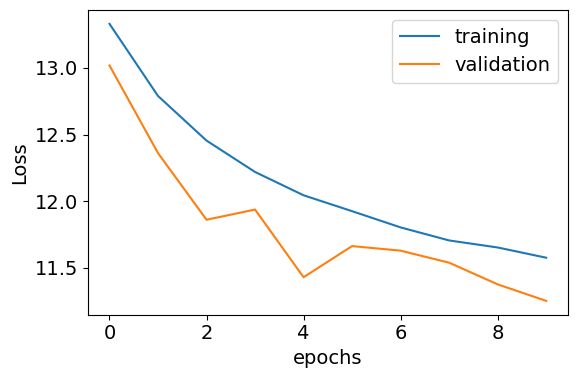

In [35]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [36]:
tdeltas = evaluate_cnn(test_loader, model, device, twoc=1)

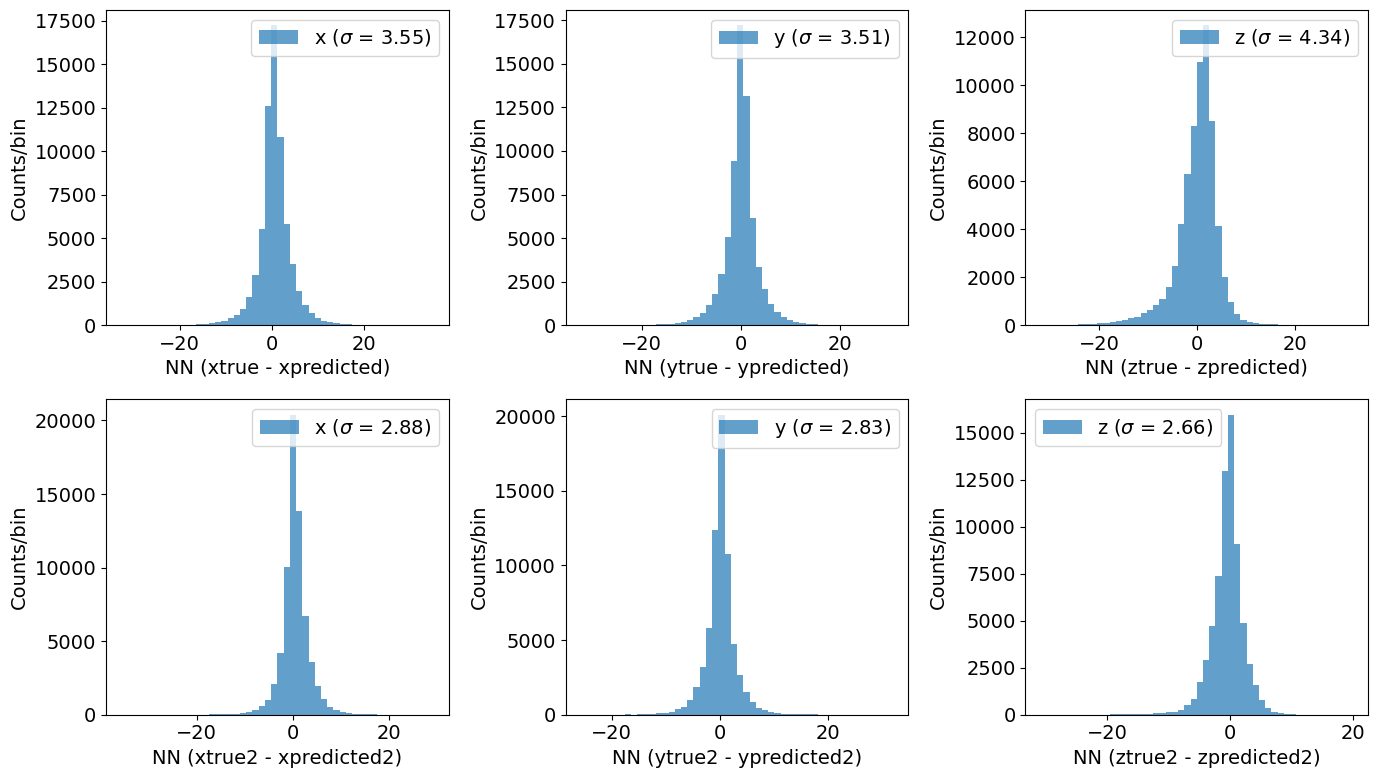

In [37]:
plotxyz_twoc(tdeltas, nbins=50)

In [38]:
f2gz, f2gx, f2gy, f2gz2, f2gx2, f2gy2 = fit_tdeltas(tdeltas, bins=100, twoc=1)

2g fit: mu1 = 1.00, sigma = 2.27, n1  =0.84
2g fit: mu2 = -1.00, sigma = 5.81, n1  =0.16
weighted error: = 2.85
2g fit: mu1 = 0.88, sigma = 3.44, n1  =0.36
2g fit: mu2 = 0.33, sigma = 1.11, n1  =0.64
weighted error: = 1.96
2g fit: mu1 = -0.05, sigma = 3.40, n1  =0.34
2g fit: mu2 = 0.15, sigma = 0.98, n1  =0.66
weighted error: = 1.80
2g fit: mu1 = -0.05, sigma = 0.76, n1  =0.55
2g fit: mu2 = -0.38, sigma = 2.58, n1  =0.45
weighted error: = 1.58
2g fit: mu1 = 0.60, sigma = 2.84, n1  =0.35
2g fit: mu2 = 0.17, sigma = 0.89, n1  =0.65
weighted error: = 1.57
2g fit: mu1 = 0.24, sigma = 0.81, n1  =0.67
2g fit: mu2 = 0.10, sigma = 2.77, n1  =0.33
weighted error: = 1.45


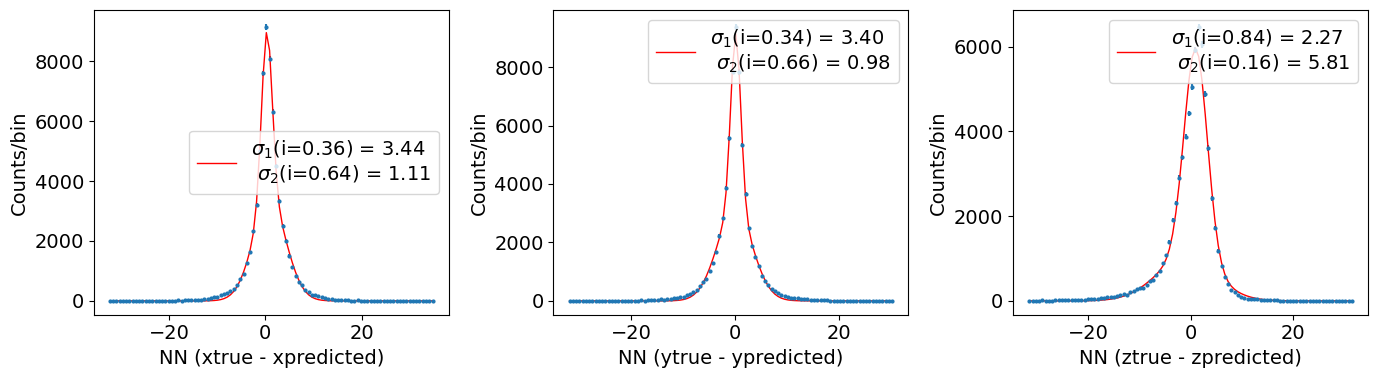

In [39]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

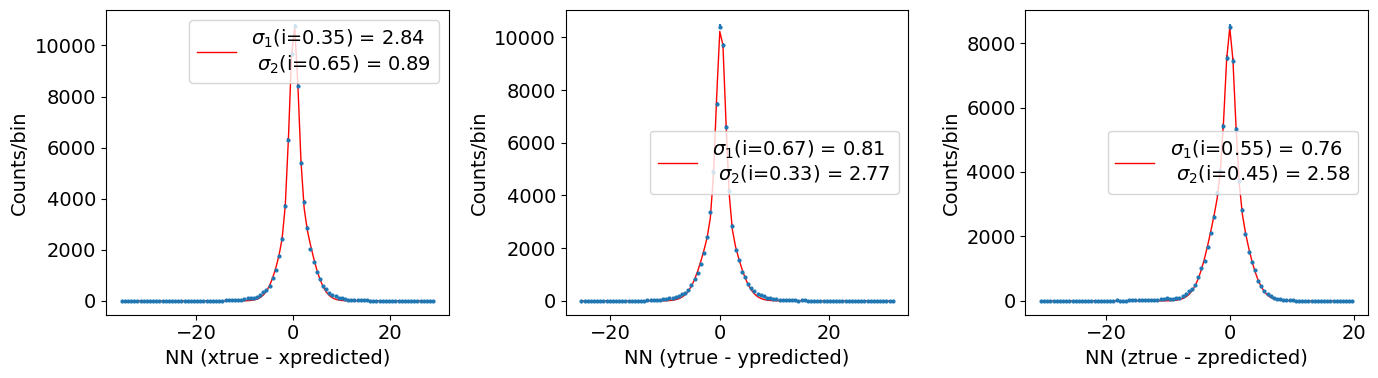

In [40]:
plotfxyz(f2gx2, f2gy2, f2gz2, figsize=(14, 4))

### Save model

In [41]:
torch.save(model.state_dict(), 'cnn_2c_csi.pth')

### Reload model

In [42]:
modelx = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, twoc=1).to(device)

In [43]:
modelx.load_state_dict(torch.load('cnn_2c_csi.pth'))

<All keys matched successfully>

In [44]:
tdeltasx = evaluate_cnn(test_loader, modelx, device, twoc=1)

input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 6])


In [45]:
xf2gz, xf2gx, xf2gy, xf2gz2, xf2gx2, xf2gy2 = fit_tdeltas(tdeltasx, bins=100, twoc=1)

2g fit: mu1 = 1.00, sigma = 2.27, n1  =0.84
2g fit: mu2 = -1.00, sigma = 5.81, n1  =0.16
weighted error: = 2.85
2g fit: mu1 = 0.88, sigma = 3.44, n1  =0.36
2g fit: mu2 = 0.33, sigma = 1.11, n1  =0.64
weighted error: = 1.96
2g fit: mu1 = -0.05, sigma = 3.40, n1  =0.34
2g fit: mu2 = 0.15, sigma = 0.98, n1  =0.66
weighted error: = 1.80
2g fit: mu1 = -0.05, sigma = 0.76, n1  =0.55
2g fit: mu2 = -0.38, sigma = 2.58, n1  =0.45
weighted error: = 1.58
2g fit: mu1 = 0.60, sigma = 2.84, n1  =0.35
2g fit: mu2 = 0.17, sigma = 0.89, n1  =0.65
weighted error: = 1.57
2g fit: mu1 = 0.24, sigma = 0.81, n1  =0.67
2g fit: mu2 = 0.10, sigma = 2.77, n1  =0.33
weighted error: = 1.45


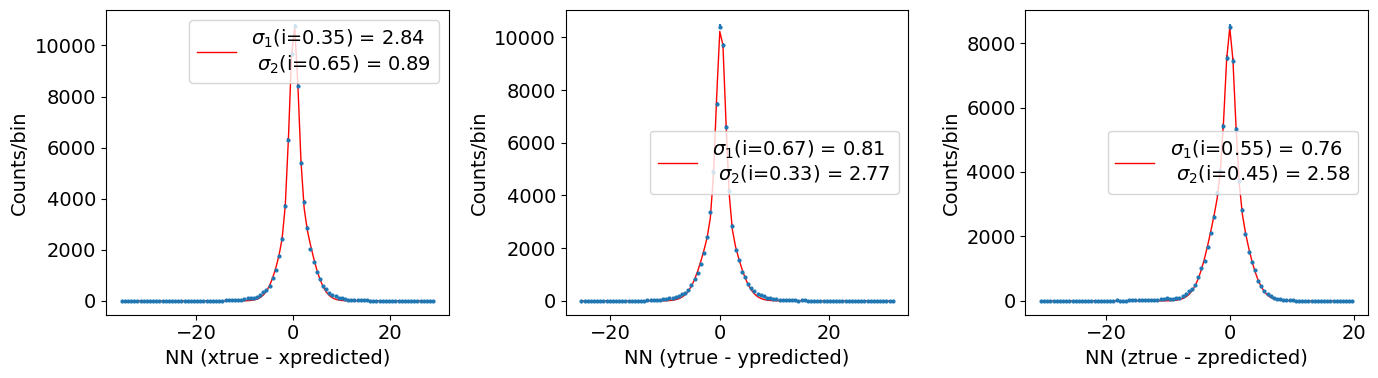

In [46]:
plotfxyz(xf2gx2, xf2gy2, xf2gz2, figsize=(14, 4))